# Finding Lane Lines on the Road

***
In this project, we will build a simple pipeline to identify lane lines on the road. We will develop the pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images).

---
<figure>
 <img src="examples/input.jpg" width="380" alt="Input Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;">An example of an input image (e.g. a frame from a video) </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/output_7_final.jpg" width="380" alt="Output Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;">The final output after applying the pipeline to the input image</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.** 

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


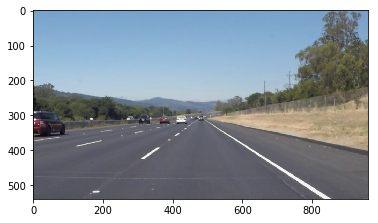

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

Below are some helper functions to that can be used implementing the pipeline.

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Lets plot some testing images first to start building and testing the pipeline:

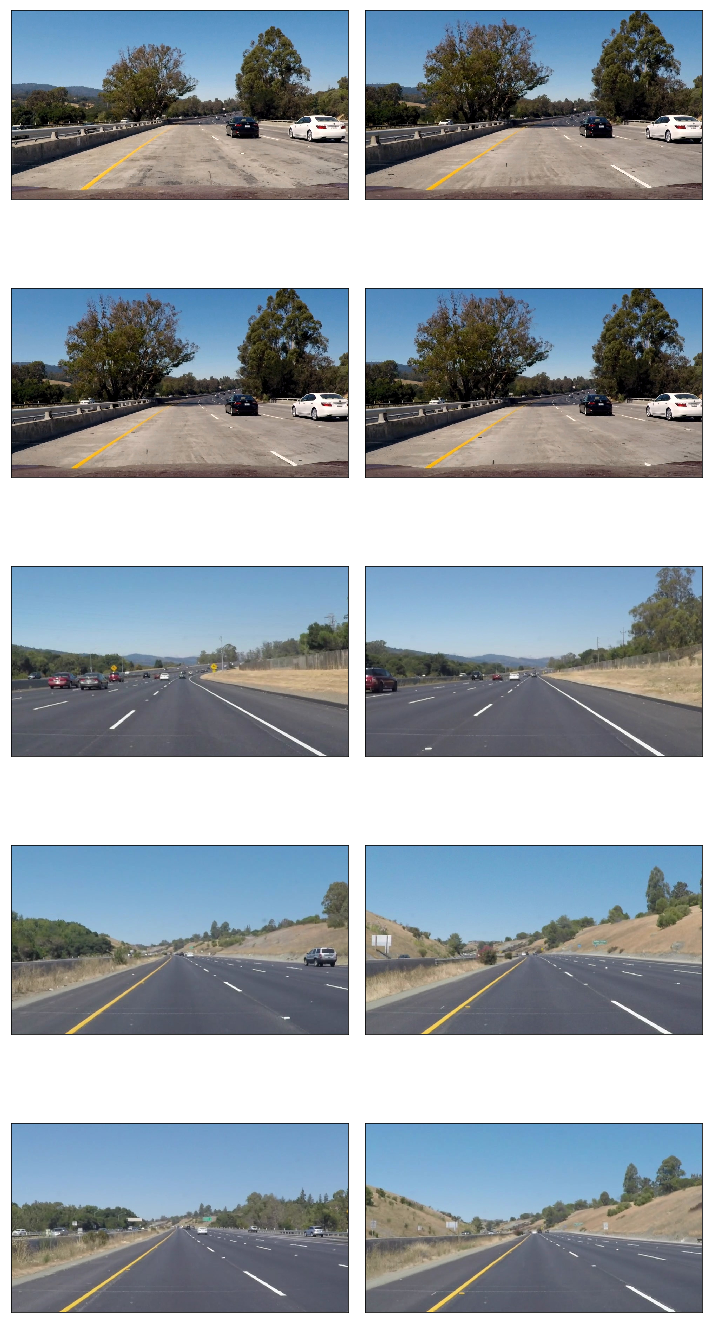

In [4]:
import os

def plot_images(images, cols = 2):
    rows = len(images) // cols
    
    plt.figure(figsize = (10, 20))
    
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.xticks([])
        plt.yticks([])
        if len(image[1].shape) > 2:
            plt.imshow(image[1])
        else:
            plt.imshow(image[1], cmap='gray')

    plt.tight_layout()
    plt.show()
    
def save_image(image, path):
    #cv2.imwrite(path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    plt.imsave(path, image)
    
def load_test_images(input_folder = "test_images"):
    return list(map(lambda file_name:(file_name, mpimg.imread(os.path.join(input_folder, file_name))), os.listdir(input_folder)))

images = load_test_images()

plot_images(images)


## Build a Lane Finding Pipeline



We can now start putting together a simple pipeline. Given the helper functions above we can think of a simple pipeline that uses the edge detection (Canny Transform) combined with the line detection (Hough Transform) in order to extract lines from an image.

### Edge Detection

We can use the canny transform to highligh edges in the image, the algorithm implemented in openCV takes in input an 8 bit image therefore we should also convert the input to a grayscale image. Moreover we can add an (additional) gaussian blur before feeding it to the canny transform in order to reduce noise

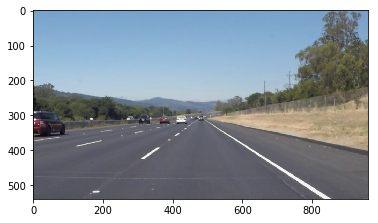

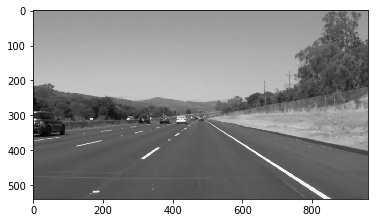

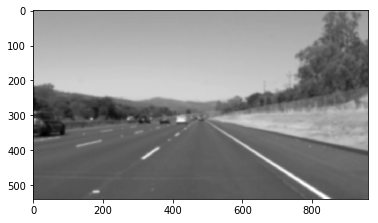

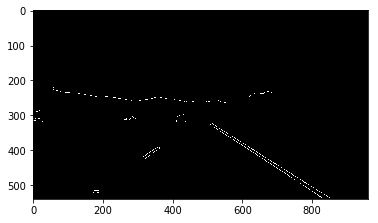

In [5]:
def blur_image(img, kernel_size = 15):
    """
    Returns the image with a gaussian blur applied to it
    """
    return gaussian_blur(img, kernel_size)

def detect_edges(img, low_threshold = 50, high_threshold = 150):
    """
    Returns the image with a Canny transformation applied on top for edge detection
    The input must be a 8-bit image.
    """
    return canny(img, low_threshold, high_threshold)

input_img = images[5][1]

plt.figure()
plt.imshow(input_img, cmap = 'gray')

# Grayscale conversion
img = grayscale(input_img)

plt.figure()
plt.imshow(img, cmap = 'gray')

# Remove noise through a gaussian filter
img = blur_image(img)

plt.figure()
plt.imshow(img, cmap = 'gray')

# Detect edges using the Canny transform
img = detect_edges(img)

plt.figure()
plt.imshow(img, cmap = 'gray')

### Region Masking

Before continuing we can improve our pipeline masking out region of the image that are not relevant for lane detection, in particular we can simply take a polygon that highlight the road ahead excluding the sky from processing.

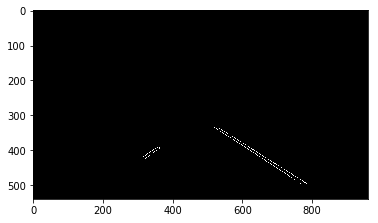

In [6]:
def mask_roi(img, region_center_gap = 50, vertical_clip_ratio = 0.62, side_clip_ratio = 0.08):
    """
    Returns the image masked with a polygon defining a region of interest, the parameters define how this region
    is build out of 4 vertices.
    """
    
    x = img.shape[1]
    y = img.shape[0]
    
    region = np.array([[(x * side_clip_ratio, y * (1 - side_clip_ratio)), 
                        (x // 2 - region_center_gap, y * vertical_clip_ratio), 
                        (x // 2 + region_center_gap, y * vertical_clip_ratio), 
                        (x * (1 - side_clip_ratio), y * (1 - side_clip_ratio))]],
                      dtype=np.int32)
    
    return region_of_interest(img, region)

img = mask_roi(img)

plt.figure()
plt.imshow(img, cmap = 'gray')

### Color Masking

Now we can test on different images and see the result, if we take the first test image we see that something is not right:

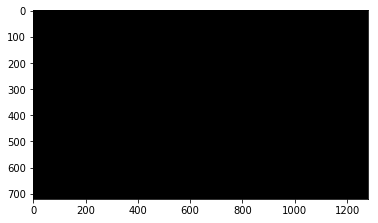

In [7]:
input_img = images[0][1]
img = grayscale(input_img)
img = blur_image(img)
img = detect_edges(img)
img = mask_roi(img)

plt.figure()
plt.imshow(img, cmap = 'gray')

If we step back to the edge detection we can see that the pipeline already failed for this example:

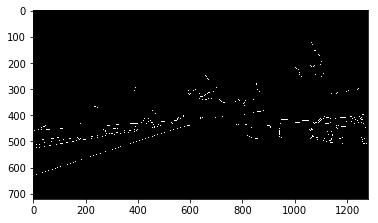

In [8]:
input_img = images[0][1]
img = grayscale(input_img)
img = blur_image(img)
img = detect_edges(img)

plt.figure()
plt.imshow(img, cmap = 'gray')

A simple pre-processing step that can be performed is to find the yellow and white regions in the input image (e.g. the colors of the road lanes), while this is not probably the best apporach it works well for simple scenarios. An interesting way to work with colors in images is actually to examine different color spaces. RGB is not very flexible as each channel affects each other. A simple guide for color selection in different color spaces can be found at https://www.learnopencv.com/color-spaces-in-opencv-cpp-python.

OpenCV provides a simple way to select ranges of colors using the inRange function. Let us proceed then adding a function to take only interesting color ranges:

In [9]:
def color_mask(img):
    """
    Creates a color mask for the yellow and white lanes
    """
    img_converted = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    white_mask = cv2.inRange(img_converted, np.array([0, 200, 0]), np.array([255, 255, 255]))
    yellow_mask = cv2.inRange(img_converted, np.array([10, 100, 150]), np.array([40, 255, 255]))

    mask = cv2.bitwise_or(white_mask, yellow_mask)

    return cv2.bitwise_and(img, img, mask = mask)


We can therefore update our pipeline adding the color masking as the initial step:

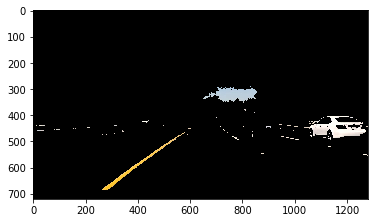

In [10]:
input_img = images[0][1]
img = color_mask(input_img)

plt.figure()
plt.imshow(img)

Rerunning the pipeline provides a better result now:

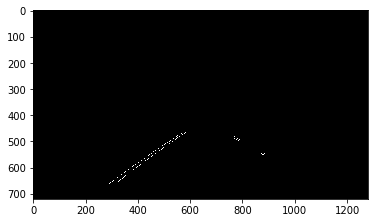

In [11]:
input_img = images[0][1]
img = color_mask(input_img)
img = grayscale(img)
img = blur_image(img)
img = detect_edges(img)
img = mask_roi(img)

plt.figure()
plt.imshow(img, cmap = 'gray')

### Lines detection

Now that we have a good image with the highlighted edges we can apply the Hough Transform to detect lines:

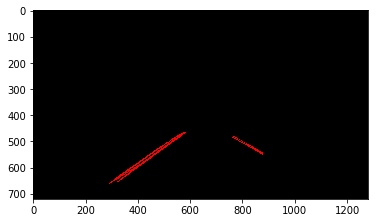

In [12]:
def extract_lines(img, threshold = 12, min_line_len = 20, max_line_gap = 200):
    return cv2.HoughLinesP(img, 1, np.pi/180, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
  
lines = extract_lines(img)
line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
draw_lines(line_img, lines, thickness = 2)

plt.figure()
plt.imshow(line_img)

We can see that the algorithm extracted multiple lines but what we need is only two lines, what we can do is simply take the average of the lines being careful in separating the left and right lines. How do we decide if a line is on the right or on the left? Well we can take its slope and positive slopes will define right lines and negative slopes will define left lines. We can also compute the average of the intercept of the line so that we can reuse it later to define our own lines with the same slope and intercept:

In [13]:
def mean_slope_intercept(lines):
    """
    Returns the average slope and intercept for the given set of lines, splitting in left and right lines.
    """
    left_lines = []
    right_lines = []
    
    if lines is None:
        return None, None
    
    for line in lines:
            
        for x1,y1,x2,y2 in line:
            
            # Skips horizontal and vertical lines
            if x1 == x2 or y1 == y2:
                continue
                
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - slope * x1
            
            angle = abs(math.atan(slope)) * 180/np.pi
            
            # Skips steeps angles
            if angle < 15 or angle > 75:
                continue
            
            if slope > 0: # Y is inversed
                right_lines.append((slope, intercept))
            elif slope < 0:
                left_lines.append((slope, intercept))
                
    left_mean = np.mean(left_lines, axis = 0) if len(left_lines) > 0 else None
    right_mean = np.mean(right_lines, axis = 0) if len(right_lines) > 0 else None
    
    return left_mean, right_mean

We now have the mean and intercept, how to use this information to draw road lanes? Well, we can simply take two y values (e.g. bottom and top of the screen) and intercept them using the respective slope and intercept of the respective left and right lines. We could take the height of the image as y1 and 0 as y2, in reality we can clip y2 to the same height of the region of interest:

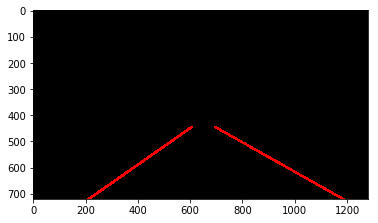

In [14]:
def get_line_coordinates(line_slope_intercept, y1, y2):
    if line_slope_intercept is None:
        return None
    """
    Returns the coordinates of a line given the input (slope, intercept) tuple and two partial coordinates
    """
    
    x1 = int((y1 - line_slope_intercept[1]) / line_slope_intercept[0])
    x2 = int((y2 - line_slope_intercept[1]) / line_slope_intercept[0])
    
    return [[x1, y1, x2, y2]]

def extract_lanes(img, lines, vertical_clip_ratio = 0.62):
    """
    Returns the right and left road lanes detected from the mean of the given set of lines.
    """
    left_line, right_line = mean_slope_intercept(lines)
    
    img_shape = img.shape
    
    lanes = []
    
    if left_line is not None:
        left_lane = get_line_coordinates(left_line, int(img_shape[1]), int(img_shape[0] * vertical_clip_ratio))
        lanes.append(left_lane)
        
    if right_line is not None:
        right_lane = get_line_coordinates(right_line, int(img_shape[1]), int(img_shape[0] * vertical_clip_ratio))
        lanes.append(right_lane)
    
    return lanes

def overlay_lanes(img, lanes, color = [255, 0, 0], thickness = 10):
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lanes, color=color, thickness=thickness)
    return line_img

lanes = extract_lanes(img, lines)

lanes_img = overlay_lanes(img, lanes)

plt.figure()
plt.imshow(lanes_img)

Now we have a nice mask with 2 lanes, we can proceed and overlay it to the original image:

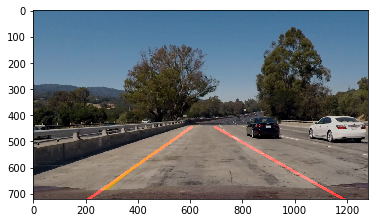

In [15]:
img = weighted_img(lanes_img, input_img)

plt.figure()
plt.imshow(img)

Putting it all together we can create a detect_lanes function encapsulates the line averaging and a process_image function that will run the entire pipeline:

In [16]:
def detect_lanes(img, threshold = 12, min_line_len = 20, max_line_gap = 200, color = [255, 0, 0], thickness = 10):
    """
    Returns the image with (potentially) two lines (left and right) drawn on top of it
    """
    lines = extract_lines(img, threshold, min_line_len, max_line_gap)
            
    lanes = extract_lanes(img, lines)
    
    return overlay_lanes(img, lanes)

def process_image(img, mask_color = True):
    
    input_img = img
    
    if mask_color:
        input_img = color_mask(img)
    
    greyscale_img = grayscale(input_img)
    
    blurred_img = blur_image(greyscale_img)
    
    edge_img = detect_edges(blurred_img)
    
    masked_img = mask_roi(edge_img)
    
    lanes_img = detect_lanes(masked_img)
        
    return weighted_img(lanes_img, img)

def process_and_save(image, output_folder = "test_images_output"):
    
    file, img = image
    processed_img = process_image(img)
    
    save_image(processed_img, os.path.join(output_folder, file))
    
    return (file, processed_img)
    


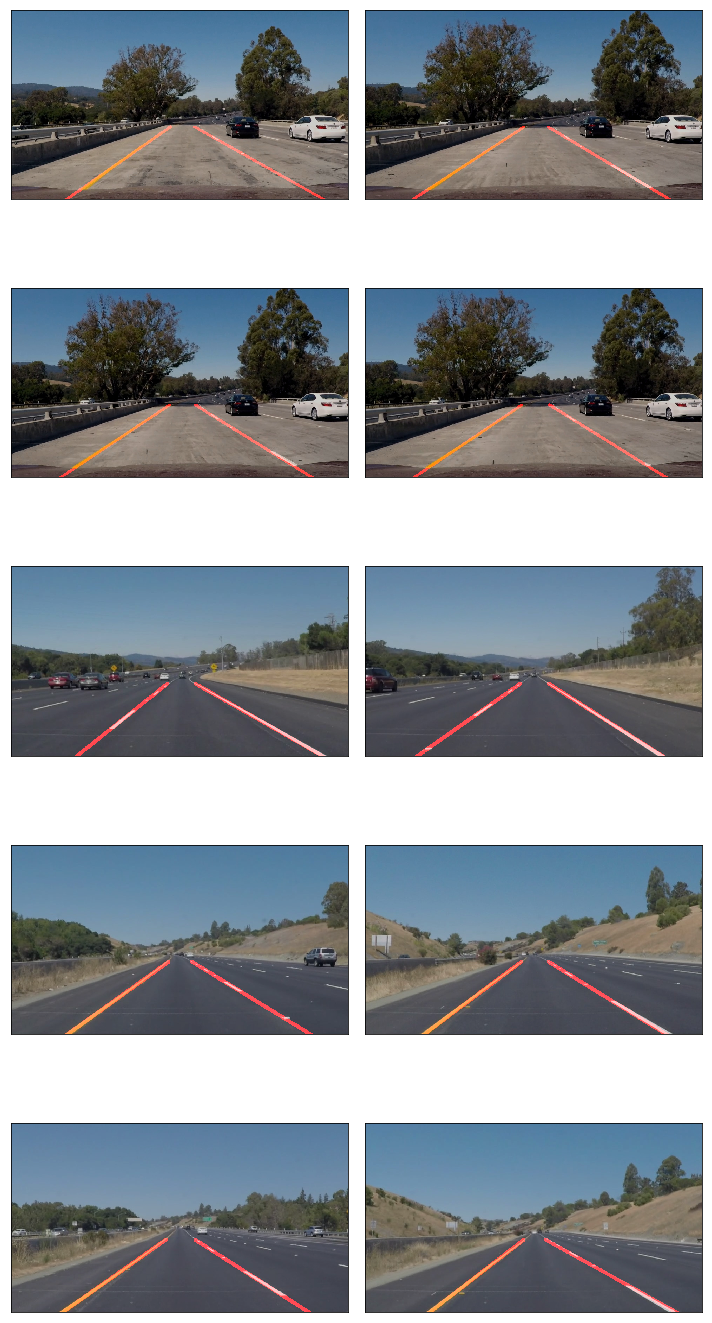

In [17]:
processed_images = list(map(process_and_save, images))

plot_images(processed_images)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test the pipeline applying the processing to each frame in the video and creating an annotated version of the video:

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_video(input_path, output_path, subclip = None, process_func = process_image):
    
    video_clip = VideoFileClip(input_path)
    
    if subclip is not None:
        video_clip = clip1.subclip(subclip[0], subclip[1])
    
    white_clip = video_clip.fl_image(process_func) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(output_path, audio=False)
    
    video_clip.reader.close()
    video_clip.audio.reader.close_proc()

Let's try the one with the solid white lane on the right first ...

In [19]:

input_path = 'test_videos/solidWhiteRight.mp4'
output_path = 'test_videos_output/solidWhiteRight.mp4'

process_video(input_path, output_path)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path))

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:03<00:00, 69.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 3.6 s


Now for the one with the solid yellow lane on the left:

In [20]:
input_path = 'test_videos/solidYellowLeft.mp4'
output_path = 'test_videos_output/solidYellowLeft.mp4'

process_video(input_path, output_path)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path))

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:09<00:00, 69.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 10.2 s


And finally on a more challenging video:

In [21]:
input_path = 'test_videos/challenge.mp4'
output_path = 'test_videos_output/challenge.mp4'

process_video(input_path, output_path)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path))

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:07<00:00, 35.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 7.85 s


### Frame interpolation

We can notice that the lanes in the video are jumpy, this happens because the lines in each frame are averaged separately from each frame. But the lanes extracted from the previous frames are actually a good indicator for averaging the lines in the current unprocessed frame. What we can do is to keep in a buffer the lanes computed from previous frames and take them into consideration when averaging the lines extracted from the current frame:

In [22]:
from collections import deque

class SmoothLaneProcessor:
    
    def __init__(self, buffer_size = 50):
        # Note that the buffer contains both the left and right lanes
        self.buffer  = deque(maxlen = buffer_size)
        
    def _detect_lanes(self, img, color = [255, 0, 0], thickness = 10, vertical_clip_ratio = 0.62):
        
        # Lines detected for the current frame
        lines = extract_lines(img)
    
        if len(self.buffer) > 0:
            # Includes the lanes from the previous frames in the lines list
            lines = np.append(lines, self.buffer, axis = 0)
    
        lanes = extract_lanes(img, lines, vertical_clip_ratio = vertical_clip_ratio)
        
        # Add the computed lanes to the buffer
        self.buffer.extend(lanes)
        
        return overlay_lanes(img, lanes, color = color, thickness = thickness)

    def process(self, img):
    
        color_masked_img = color_mask(img)

        greyscale_img = grayscale(color_masked_img)

        blurred_img = blur_image(greyscale_img)

        edge_img = detect_edges(blurred_img)

        masked_img = mask_roi(edge_img)

        lanes_img = self._detect_lanes(masked_img)

        return weighted_img(lanes_img, img)


We now have a class that keeps the lanes computed in the previous frames in a buffer and includes them in the list of lines before averaging. This leads to a smoothing of the lanes shown in the annotated video:

In [23]:
processor = SmoothLaneProcessor()

input_path = 'test_videos/challenge.mp4'
output_path = 'test_videos_output/challenge_smooth.mp4'

process_video(input_path, output_path, process_func = processor.process)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path))

[MoviePy] >>>> Building video test_videos_output/challenge_smooth.mp4
[MoviePy] Writing video test_videos_output/challenge_smooth.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:07<00:00, 36.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_smooth.mp4 

Wall time: 7.89 s


The output is a bit smoother, increasing the buffer size may lead to better results.